In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import pandas as pd
import numpy as np
from joblib import dump

We will load our processed data.

In [16]:
X_train = pd.read_csv('../data/processed/X_train.csv')
X_val = pd.read_csv('../data/processed/X_val.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
y_val = pd.read_csv('../data/processed/y_val.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')

In [17]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()

### 2. Logistic Classification

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

Fit the model before hyperparameter tuning.

In [19]:
log_reg = LogisticRegression(random_state=8, max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=8)

In [20]:
from joblib import dump

dump(log_reg, '../models/log_reg_1.joblib')

['../models/log_reg_1.joblib']

In [21]:
def logit(model):
    y_train_probs = model.predict_proba(X_train)[:, 1]
    y_val_probs = model.predict_proba(X_val)[:, 1]

    train_score = pd.DataFrame({'roc-auc score': roc_auc_score(y_train, y_train_probs)}, index=['Training Set'])
    val_score = pd.DataFrame({'roc-auc score': roc_auc_score(y_val, y_val_probs)}, index=['Validation Set'])

    score = pd.concat([train_score, val_score])
    print(score)
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
    
    plt.plot(fpr_train, tpr_train, label='Train ROC-curve')
    plt.plot(fpr_val, tpr_val, label='Validate ROC-curve')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-Curve')
    plt.legend()
    
    plt.show()

                roc-auc score
Training Set         0.993600
Validation Set       0.993005


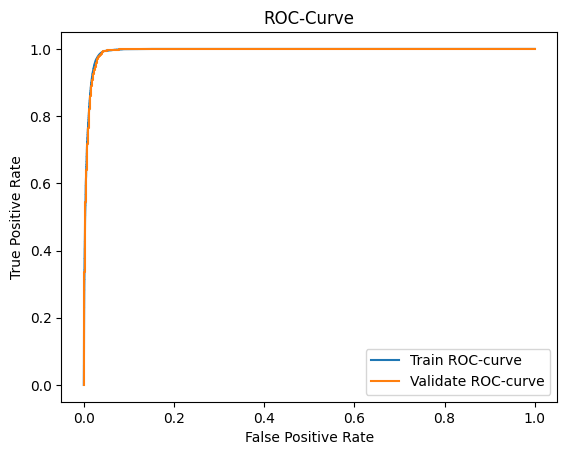

In [23]:
logit(log_reg)

In [24]:
def submission_file(y_test_prob):
    player_id_df = pd.read_csv('../data/processed/player_id.csv')
    
    submission_df = pd.DataFrame({
        'player_id': player_id_df['player_id'],
        'drafted': y_test_prob
    })
    
    submission_df['drafted'] = submission_df['drafted'].round(1)
    return submission_df

In [25]:
y_test_probs = log_reg.predict_proba(X_test)[:, 1]

In [26]:
submission_1 = submission_file(y_test_probs)

In [28]:
submission_1.to_csv('../data/submission/submission_1_logit.csv', index=False)

In [29]:
submission_1[submission_1['drafted'] != 0]

,player_id,drafted
4,73b960f9-27b8-4431-9d23-a760e9bbc360,0.2
13,26544ebf-a284-48b3-a2c8-dcccb0fd989a,0.5
15,bff62a81-ffeb-416b-bc74-87c8dfac53cf,0.1
22,843bf833-1ae8-4ecc-860b-274768e342a6,0.6
23,68fe79dc-50ba-4a49-8d5f-77e6a97efeb3,0.1
...,...,...
4759,fae50ad7-1b6a-4a8c-9152-3b65d6888e18,0.5
4763,4ad095fd-045c-4887-a87a-e4faae16973d,0.1
4915,cbd02af9-3fe7-4127-923f-33fdd89a18e6,0.1
4931,614133b8-4955-438a-89d1-4e8914e7c69c,0.2


#### Hyperparameter Tuning with C

Smaller values specify stronger regularization

default = 1

In [135]:
c = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [136]:
train_score = []
val_score = []
    
for i in c:
    log = LogisticRegression(random_state=8, max_iter=2000, C=i).fit(X_train, y_train)
    y_train_probs = log.predict_proba(X_train)[:, 1]
    y_val_probs = log.predict_proba(X_val)[:, 1]
        
    train_score.append(roc_auc_score(y_train, y_train_probs))
    val_score.append(roc_auc_score(y_val, y_val_probs))       
    
score = pd.DataFrame({'train_score': train_score,
                         'val_score': val_score}, index=c)
print(score)

          train_score  val_score
0.001        0.992993   0.993133
0.010        0.997817   0.997847
0.100        0.999560   0.999503
1.000        0.999824   0.999788
10.000       0.999860   0.999822
100.000      0.999866   0.999827
1000.000     0.999868   0.999829


#### Hyperparameter Tuning with Solver

default = lgfgs

In [130]:
solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']

In [138]:
train_score = []
val_score = []
C = 1000
max_iter = 2000
    
for i in solver:
    log = LogisticRegression(random_state=8, max_iter=max_iter, C=C, solver=i).fit(X_train, y_train)
    y_train_probs = log.predict_proba(X_train)[:, 1]
    y_val_probs = log.predict_proba(X_val)[:, 1]
        
    train_score.append(roc_auc_score(y_train, y_train_probs))
    val_score.append(roc_auc_score(y_val, y_val_probs))       
    
score = pd.DataFrame({'train_score': train_score,
                         'val_score': val_score}, index=solver)
print(score)

/Users/narongvatchingpayakmon/Projects/adv_mla_2023/adv_mla_2023_at1_14229898/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narongvatchingpayakmon/Projects/adv_mla_2023/adv_mla_2023_at1_14229898/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


                 train_score  val_score
lbfgs               0.999868   0.999829
liblinear           0.999865   0.999825
newton-cg           0.999868   0.999829
newton-cholesky     0.999867   0.999829
sag                 0.999296   0.999206
saga                0.998724   0.998650


#### Hyperparameter Tuning with Penalty

Penalties support by solver were 'l2', and 'none'

default = l2

In [143]:
penalty = ['l2', 'none']

In [144]:
train_score = []
val_score = []
C = 1000
max_iter = 2000
solver = 'lbfgs'
    
for i in penalty:
    log = LogisticRegression(random_state=8, max_iter=max_iter, C=C, solver=solver, penalty=i).fit(X_train, y_train)
    y_train_probs = log.predict_proba(X_train)[:, 1]
    y_val_probs = log.predict_proba(X_val)[:, 1]
        
    train_score.append(roc_auc_score(y_train, y_train_probs))
    val_score.append(roc_auc_score(y_val, y_val_probs))       
    
score = pd.DataFrame({'train_score': train_score,
                         'val_score': val_score}, index=penalty)
print(score)

/Users/narongvatchingpayakmon/Projects/adv_mla_2023/adv_mla_2023_at1_14229898/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/narongvatchingpayakmon/Projects/adv_mla_2023/adv_mla_2023_at1_14229898/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


      train_score  val_score
l2       0.999868   0.999829
none     0.999868   0.999830


#### Hyperparameter Tuning with Multi-Class Handling

default = auto

In [145]:
multi_class = ['auto', 'ovr', 'multinomial']

In [146]:
train_score = []
val_score = []
C = 1000
max_iter = 2000
solver = 'lbfgs'
penalty = 'none'
    
for i in multi_class:
    log = LogisticRegression(random_state=8, max_iter=max_iter, C=C, solver=solver, penalty=penalty, multi_class=i).fit(X_train, y_train)
    y_train_probs = log.predict_proba(X_train)[:, 1]
    y_val_probs = log.predict_proba(X_val)[:, 1]
        
    train_score.append(roc_auc_score(y_train, y_train_probs))
    val_score.append(roc_auc_score(y_val, y_val_probs))       
    
score = pd.DataFrame({'train_score': train_score,
                         'val_score': val_score}, index=multi_class)
print(score)

/Users/narongvatchingpayakmon/Projects/adv_mla_2023/adv_mla_2023_at1_14229898/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/narongvatchingpayakmon/Projects/adv_mla_2023/adv_mla_2023_at1_14229898/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/narongvatchingpayakmon/Projects/adv_mla_2023/adv_mla_2023_at1_14229898/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/narongvatchingpayakmon/Projects/adv_mla_2023/adv_mla_2023_at1_14229898/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:118

             train_score  val_score
auto            0.999868    0.99983
ovr             0.999868    0.99983
multinomial     0.999868    0.99983


### Model after hyperparameter tuning

In [182]:
log_reg_tune = LogisticRegression(random_state=8, max_iter=2000, solver='lbfgs', penalty='none', multi_class='auto')
log_reg_tune.fit(X_train, y_train)

/Users/narongvatchingpayakmon/Projects/adv_mla_2023/adv_mla_2023_at1_14229898/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LogisticRegression(max_iter=2000, penalty='none', random_state=8)

In [187]:
dump(log_reg_tune, '../models/log_reg_tune.joblib')

['../models/log_reg_tune.joblib']

                roc-auc score
Training Set         0.999868
Validation Set       0.999830


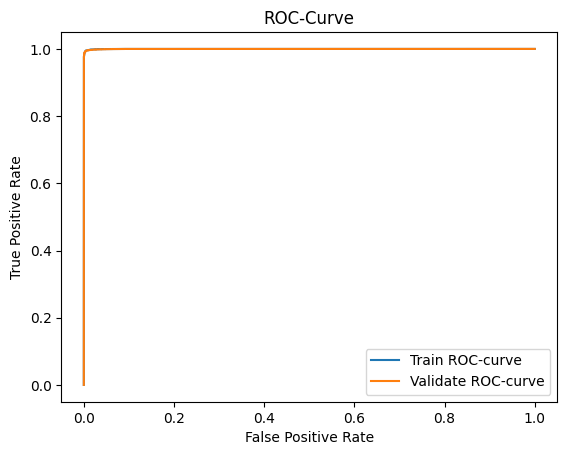

In [188]:
logit(log_reg_tune)

In [190]:
y_test_probs_2 = log_reg_tune.predict_proba(X_test)[:, 1]

In [191]:
submission_2 = submission_file(y_test_probs_2)

In [192]:
submission_2

,player_id,drafted
0,cf302b4d-84f7-4124-a25d-a75eed31978b,0.0
1,f91837cd-4f49-4b70-963d-aeb82c6ce3da,0.0
2,53ec2a29-1e7d-4c6d-86d7-d60d02af8916,0.0
3,32402798-471c-4a54-8cb4-29cd95199014,0.0
4,73b960f9-27b8-4431-9d23-a760e9bbc360,0.0
...,...,...
4965,a25ee55f-02a3-4f8e-8194-a5f427e14e7c,0.0
4966,d0d9f45e-7b01-44b3-8d40-514ec338611d,0.0
4967,f8df22c4-1602-4fab-896d-8820951aae2f,0.0
4968,b791c69a-f769-4163-afda-051a6fd20a9d,0.0


In [193]:
submission_2.to_csv('../data/submission/submission_2.csv', index=False)